In [0]:
#!pip3 install --upgrade pandas
#!pip3 install nltk
#!pip3 install --upgrade numpy
#!pip3 install tensorflow
#!pip3 install gensim
#!pip3 install sklearn


In [0]:
import pandas as pd
import nltk

In [0]:
def load_data(file_name):
    
    # columns other than stars are labels
    df = pd.read_csv(file_name)
    return df[df.columns.difference(['stars'])]

In [0]:
def load_labels(file_name):
# extract stars column as label
    return pd.read_csv(file_name)["stars"] - 1

In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
stopwords = stopwords.difference(["above","again","against","below", "any", "no", "not", "off", "over", "should", "why"])
stopwords.update(["ve", "'m", "'s", "'d"])

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

model_glove_twitter = api.load("glove-twitter-50")

def filter_stopwords(tokens):
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def filter_punctuations(tokens):
    # filter unnecessary quotations, including quotations, footstop, comma.
    punctuations = ["''","``", ".", ",", "(", ")", "--", "-", ":",";","'", "&"]
    return [token for token in tokens if token not in punctuations]

def convert_to_lower_case(tokens):
    # return [token.lower() for token in tokens] # inefficient
    return list(map(str.lower, tokens))

def stem(tokens):
    sno = nltk.stem.SnowballStemmer('english')
    return [sno.stem(token) for token in tokens]

def filter_word2vec(tokens):
    return [token for token in tokens if token in model_glove_twitter.vocab]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# stopwords

In [0]:
def remove_contractions(tokens):
    con = {"don't", "doesn't", "wouldn't", "won't", "isn't", "aren't", "didn't", "was't", " weren't", "shouldn't", "n't"}
    result = []
    for token in tokens:
        if token in con:
            result.append("not")
        else:
            result.append(token)
    return result

In [0]:
def apply_on_text(df, func):
    # apply function func on the text of df
    text = df['text']
    text = text.apply(lambda x: func(x))
    df['text'] = text
    return df

In [0]:
def preprocess_date(df):
    datetime = pd.to_datetime(df["date"])
    df['year'] = datetime.dt.year
    df['month'] = datetime.dt.month
    df['weekday'] = datetime.dt.day_name() # extract weekday from date
    df['time'] = datetime.dt.hour.apply(lambda x: 
                                        0 if x<6
                                       else 1 if x<12
                                        else 2 if x<18
                                        else 3) # extract time from date

In [0]:
trainset = load_data("data/train.csv")
validset = load_data("data/valid.csv")
testset = load_data("data/test.csv")

trainset_label = load_labels("data/train.csv")
validset_label = load_labels("data/valid.csv")

In [0]:
def preprocess_model(df):
    
    ### add layer here if need more preprocessing ###
    apply_on_text(df, nltk.word_tokenize) # tokenize
    apply_on_text(df, convert_to_lower_case) # convert_to_lower_case
    apply_on_text(df, remove_contractions)
    apply_on_text(df, filter_stopwords) # filter stopwords
    apply_on_text(df, filter_punctuations) # filter puncations
    #apply_on_text(df, stem) # stem_word
    apply_on_text(df, filter_word2vec)
    preprocess_date(df)
    
    return df
    

In [0]:
# preprocess text, takes some time to run because of large sample size
# about 30 seconds
trainset = preprocess_model(trainset)
validset = preprocess_model(validset)
testset = preprocess_model(testset)

## !!! Preprocess End Here, Can Start Build Model !!!

inputs and target labels (stars) are already separated into two dataframe

inputs is stored in <b>trainset</b> & <b>validset</b>
output is stored in <b>trainset_label</b> & <b>validset_label</b> 

In [0]:
# I have separated inputs and target labels into two dataframe
trainset # this is the inputs

,business_id,cool,date,funny,review_id,text,useful,user_id,year,month,weekday,time
0,4wjJe3AxFyVOSMHLRh68Og,8,2009-08-22 21:06:56,10,ygjO-o4_YoXr41D7Rx9vmw,"[recreation, ?, oh, usual, bowl, drive, around...",9,K0sapHOlhlGNjx3GBeSf5A,2009,8,Saturday,3
1,xGXzIliuZ6FgMS870UjPRw,0,2017-08-24 16:53:53,0,MN5bVycm01xc7V3PPBPoMQ,"[burgers, good, good, fries, used, get, rings,...",0,ykiNDnGo_66TsjknglEcjQ,2017,8,Thursday,2
2,wdwODzBChLIh_u8V8CPpyA,0,2014-08-15 02:31:54,0,9eDWY5cevgRhywg6uTm8Pw,"[three, times, twice, not, guacamole, took, fa...",0,4y3C9Mml09FzFk6rq6_g2Q,2014,8,Friday,0
3,n8Zqqhff-2cxzWt_nwhU2Q,1,2015-06-30 03:48:18,1,Zt9Yj5K1Y-MnDmocXI9Zgw,"[pretty, excited, discover, cali, gastropub, a...",1,PH7HEuAqSQgOGDi7Ygnulg,2015,6,Tuesday,0
4,Em2ZuYiyTr4_ITSCTi86CQ,0,2018-05-25 22:29:25,0,qPR0JlNSMChgCjxY3yyiEw,"[pleased, care, receive, going, since, five, d...",0,5uKGIkrQRISzQCSA6DXtow,2018,5,Friday,3
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,aLdMqYoHqc77JjOybdPX-A,0,2013-11-20 22:33:16,0,VCW3BF9uyfgTz8wTs-MbqA,"[burgers, taste, frozen, dry, gone, mutiple, t...",0,rBj5N0MxsbvwlhAoMYpxTA,2013,11,Wednesday,3
19996,9n8jDTvkOjoH3fD_Y9KC1g,0,2015-02-01 23:22:31,3,ULQwNu6mE_TOpwlD3GBnHg,"[think, common, knowledge, airport, food, like...",1,n3z1iSEGynVgMK_nHmzryA,2015,2,Sunday,3
19997,K-HCIVG4ZWjDaSMAuGAW7A,0,2012-08-30 22:28:10,1,Gov9ElQA5wi7j87l5DxFng,"[looking, barber, shop, good, price, customer,...",4,wrp6Ekew1ohFOBXG3t6zTA,2012,8,Thursday,3
19998,pQ6hEVe7KPw28W07Lcoc8A,0,2010-01-07 01:03:31,0,kAzAgREZZe05HrYbDxaeqw,"[checked, place, recent, trip, vegas, im, huge...",0,NPo_Yh1C5BwCoSVLNcjw1A,2010,1,Thursday,0


# Working on model (RNN)

In [0]:
import csv
import tensorflow as tf

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
vocab_size = 8192
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")

In [0]:
#embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'

train_sequences = trainset['text']
tokenizer.fit_on_texts(train_sequences)
train_sequences = tokenizer.texts_to_sequences(trainset['text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = validset['text']
validation_sequences = tokenizer.texts_to_sequences(validset['text'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = testset['text']
test_sequences = tokenizer.texts_to_sequences(testset['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_number = trainset[['cool','funny','useful']]
valid_number = validset[['cool','funny','useful']]
test_number = testset[['cool','funny','useful']]


In [0]:
train_category = trainset[['user_id','business_id', 'year', 'month','weekday','time']]
valid_category = validset[['user_id','business_id', 'year', 'month','weekday','time']]
test_category = testset[['user_id','business_id', 'year', 'month','weekday','time']]

In [0]:
bid_counts = train_category['business_id'].value_counts()
common_bid = bid_counts[bid_counts > 5].index
train_category.loc[~train_category["business_id"].isin(common_bid), "business_id"] = "Uncommon"
valid_category.loc[~valid_category["business_id"].isin(common_bid), "business_id"] = "Uncommon"
test_category.loc[~test_category["business_id"].isin(common_bid), "business_id"] = "Uncommon"

uid_counts = train_category['user_id'].value_counts()
common_uid = uid_counts[uid_counts > 5].index
train_category.loc[~train_category["user_id"].isin(common_uid), "user_id"] = "Uncommon"
valid_category.loc[~valid_category["user_id"].isin(common_uid), "user_id"] = "Uncommon"
test_category.loc[~test_category["user_id"].isin(common_uid), "user_id"] = "Uncommon"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_category)

train_cat = encoder.transform(train_category).toarray()
valid_cat = encoder.transform(valid_category).toarray()
test_cat = encoder.transform(test_category).toarray()

In [0]:
def get_weight_matrix():
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, model_glove_twitter.vector_size))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for i in range(len(tokenizer.index_word)):
        if i > 1 and i < vocab_size:
          weight_matrix[i] = model_glove_twitter[tokenizer.index_word[i]]
    return weight_matrix

embedding_vectors = get_weight_matrix()

In [0]:

from tensorflow.keras import backend as K

def swish(x):
    return x*K.sigmoid(x)
"""
def custom_function(x):
    return 0.5+ 5* K.sigmoid(x)

def accuracy(y_true, y_pred):
    return K.mean(K.round(y_pred) == y_true)

def loss(y_true, y_pred):
    y_error = K.abs(y_pred - y_true)
    bool_idx = K.greater(y_error, 0.5)
    loss1 = 0.2 * y_error 
    loss2 = y_error
    loss = K.switch(bool_idx, loss2, loss1)
    return K.mean(loss)
"""


'\ndef custom_function(x):\n    return 0.5+ 5* K.sigmoid(x)\n\ndef accuracy(y_true, y_pred):\n    return K.mean(K.round(y_pred) == y_true)\n\ndef loss(y_true, y_pred):\n    y_error = K.abs(y_pred - y_true)\n    bool_idx = K.greater(y_error, 0.5)\n    loss1 = 0.2 * y_error \n    loss2 = y_error\n    loss = K.switch(bool_idx, loss2, loss1)\n    return K.mean(loss)\n'

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

text_input = Input(shape=(max_length,))
embedding_1 = tf.keras.layers.Embedding(vocab_size, model_glove_twitter.vector_size, weights=[embedding_vectors], input_length=max_length)(text_input)
RNN = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, dropout=0.5, recurrent_dropout=0.5))(embedding_1)

number_input = Input(shape=(3,))
dense_1 = tf.keras.layers.Dense(32, activation=swish)(number_input)
dropout_1 = tf.keras.layers.Dropout(0.7)(dense_1)

cat_input = Input(shape=(train_cat.shape[1]),)
dense_3 = tf.keras.layers.Dense(32, activation=swish)(cat_input)
dropout_3 = tf.keras.layers.Dropout(0.75)(dense_3)

merge = concatenate([RNN, dropout_1, dropout_3])
batch_norm1 = tf.keras.layers.BatchNormalization()(merge)
dense_2 = tf.keras.layers.Dense(32, activation=swish)(batch_norm1)
dropout_2 = tf.keras.layers.Dropout(0.5)(dense_2)
output = tf.keras.layers.Dense(5, activation='softmax')(dropout_2)

model2 = Model(inputs=[text_input, number_input, cat_input], outputs=output)

model2.summary() 

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 202)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 50)      409600      input_16[0][0]                   
____________________________________________________________________________________________

Working on the model

In [0]:
# model.compile(loss=loss , optimizer='adam', metrics=[accuracy])
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100

history = model2.fit([train_padded,train_number, train_cat], 
                    trainset_label, 
                    epochs=num_epochs, 
                    batch_size=512,
                    validation_data=([validation_padded, valid_number, valid_cat], validset_label), 
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=6, min_delta=0.0001, restore_best_weights=True)]
                    )

Epoch 1/100
40/40 [==============================] - 75s 2s/step - loss: 1.7925 - accuracy: 0.2880 - val_loss: 1.4790 - val_accuracy: 0.4555
Epoch 2/100
40/40 [==============================] - 73s 2s/step - loss: 1.4921 - accuracy: 0.3932 - val_loss: 1.4149 - val_accuracy: 0.4740
Epoch 3/100
40/40 [==============================] - 73s 2s/step - loss: 1.3952 - accuracy: 0.4313 - val_loss: 1.3110 - val_accuracy: 0.5095
Epoch 4/100
40/40 [==============================] - 73s 2s/step - loss: 1.2897 - accuracy: 0.4773 - val_loss: 1.4149 - val_accuracy: 0.4665
Epoch 5/100
40/40 [==============================] - 73s 2s/step - loss: 1.1798 - accuracy: 0.5204 - val_loss: 1.0691 - val_accuracy: 0.5645
Epoch 6/100
40/40 [==============================] - 72s 2s/step - loss: 1.1198 - accuracy: 0.5426 - val_loss: 1.0729 - val_accuracy: 0.5620
Epoch 7/100
40/40 [==============================] - 75s 2s/step - loss: 1.0712 - accuracy: 0.5684 - val_loss: 0.9937 - val_accuracy: 0.5930
Epoch 8/100
4

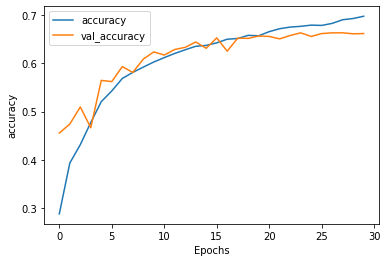

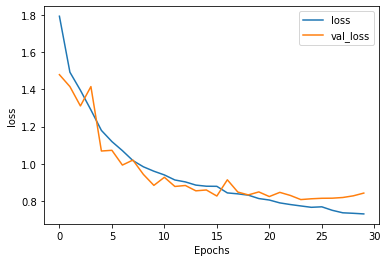

In [0]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
val_result = model2.predict([validation_padded, valid_number, valid_cat]) 

val_result = val_result.argmax(axis = 1) +1

In [0]:
df = pd.DataFrame(data = {'review_id': validset['review_id'],'stars': val_result})
df.to_csv(root_path + "data/validation-pred.csv")

In [0]:
test_result = model2.predict([test_padded, test_number, test_cat]) 

test_result = test_result.argmax(axis = 1) +1

In [0]:
df = pd.DataFrame(data = {'review_id': testset['review_id'],'stars': test_result})
df.to_csv(root_path + "data/pred.csv")